In [2]:
import pandas as pd
import matplotlib.pyplot as plt   # ajuste: matplotlib.pyplot
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

# caminho correto do arquivo no Colab
df = pd.read_csv('/content/previsao_de_renda2.csv')

# visualizar as primeiras linhas
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.419e+04
Date:                Mon, 12 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:12:25   Log-Likelihood:            -7.4519e+05
No. Observations:              525000   AIC:                         1.490e+06
Df Residuals:                  524975   BIC:                         1.491e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

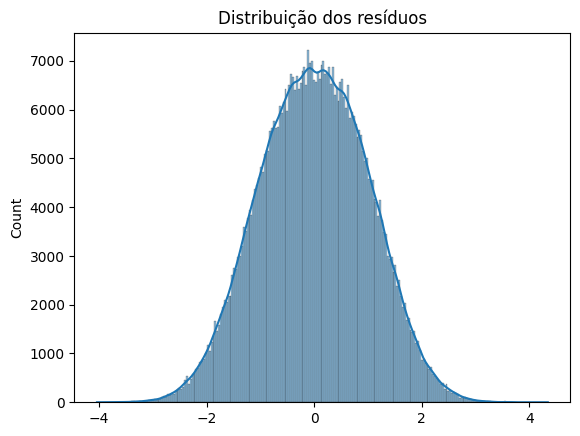

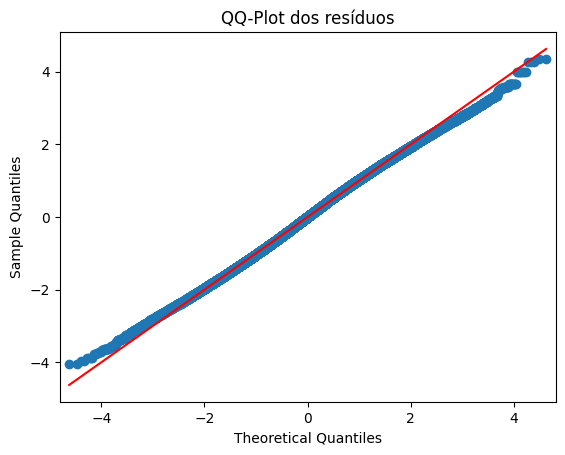

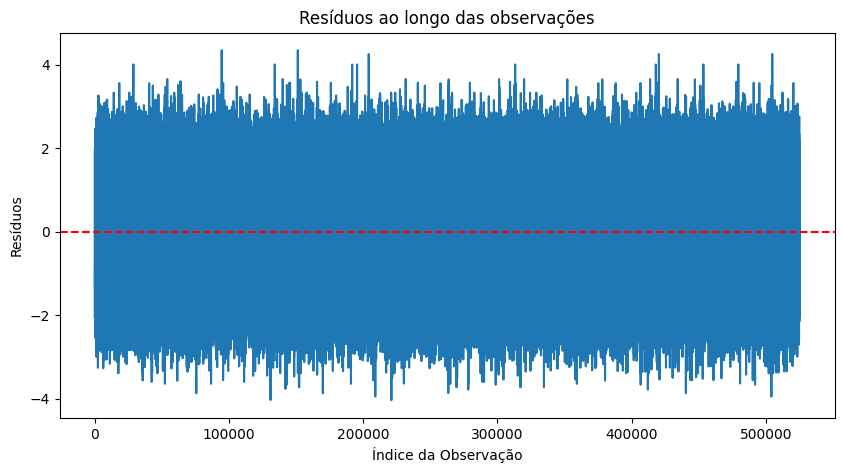

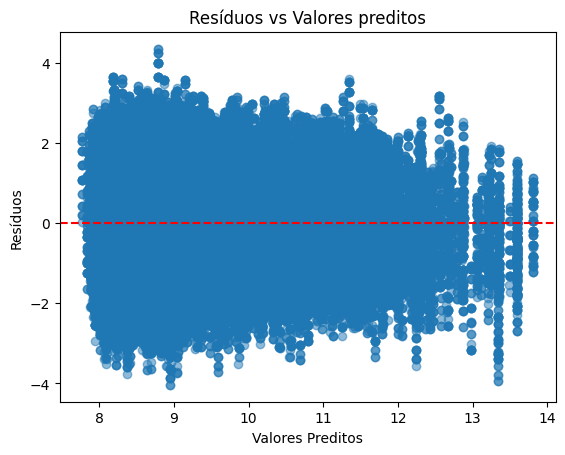

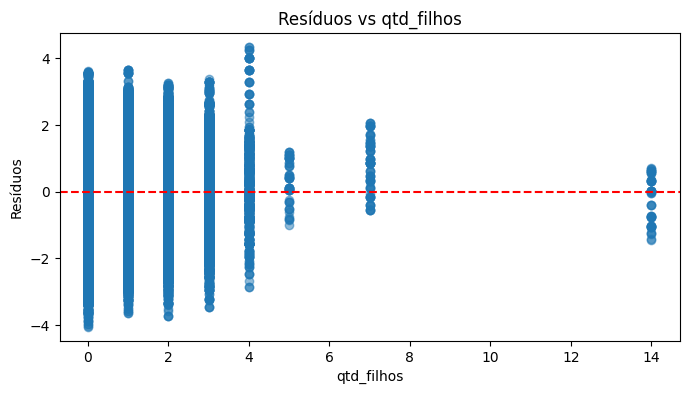

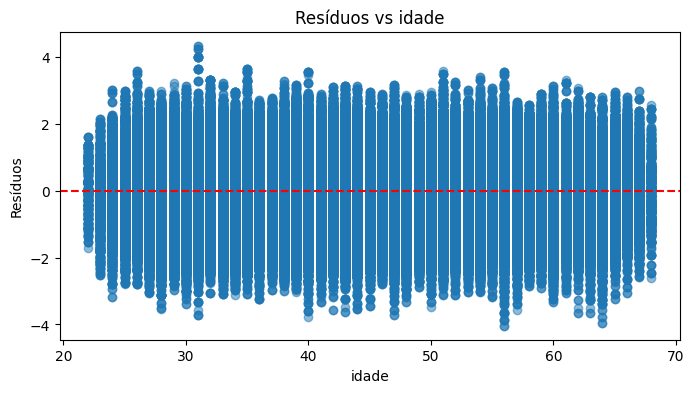

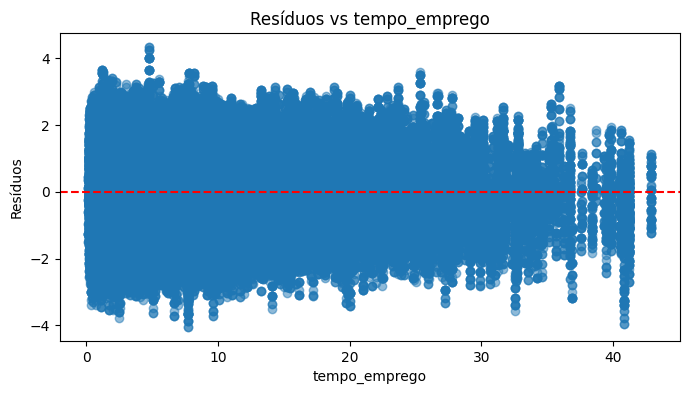

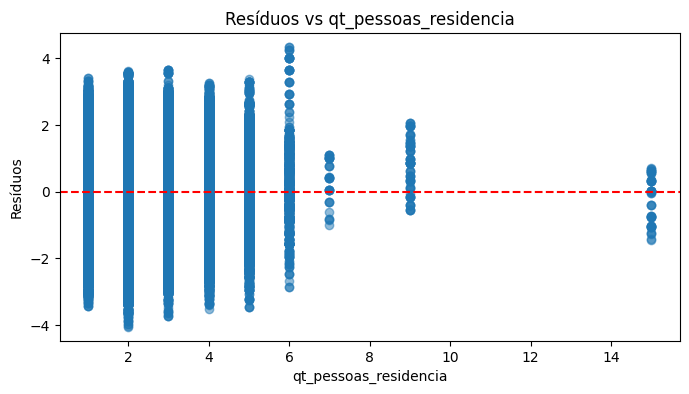

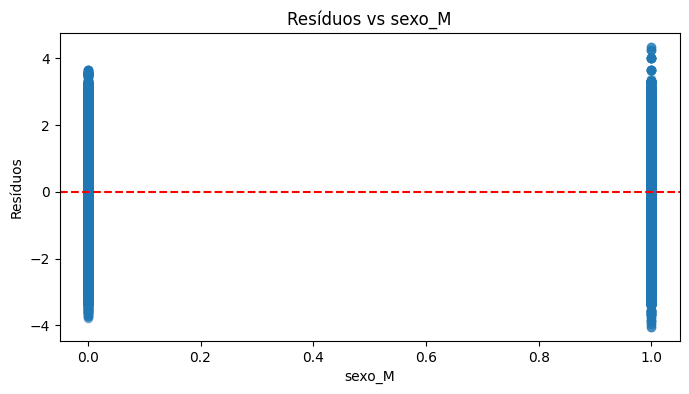

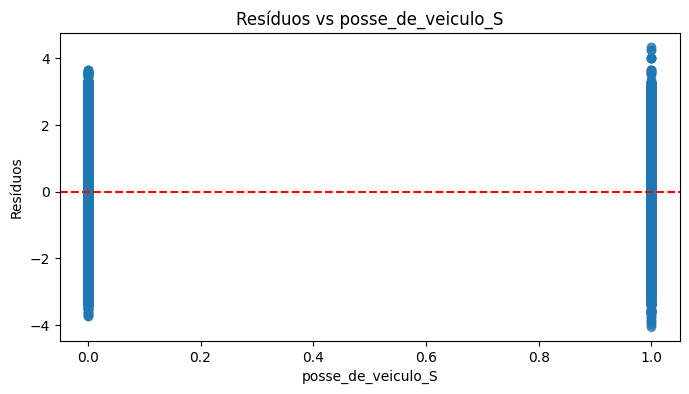

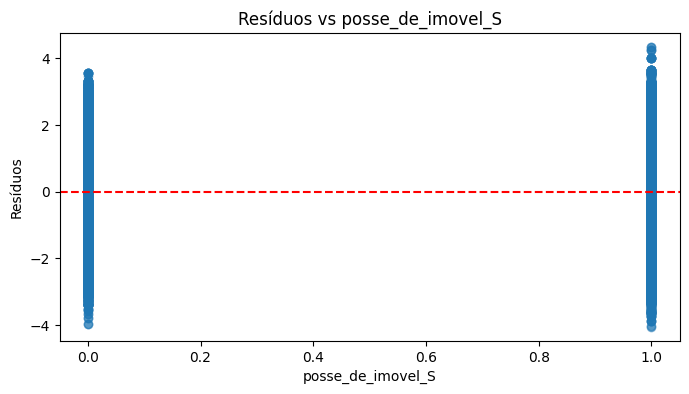

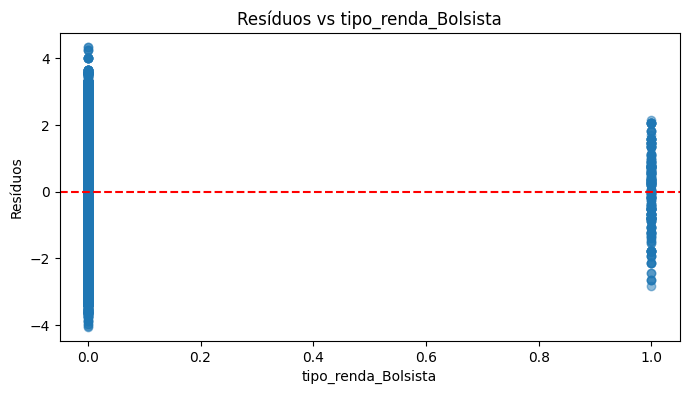

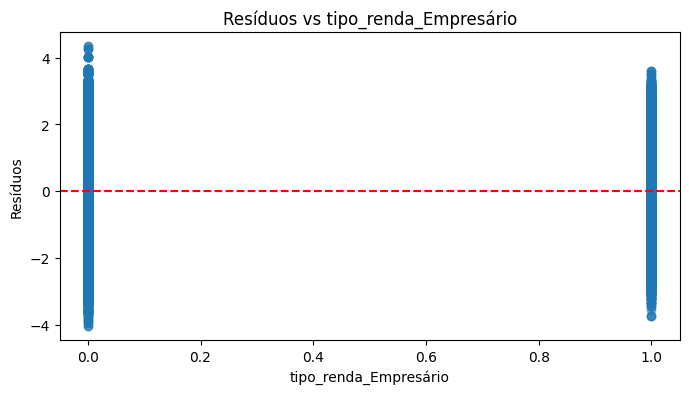

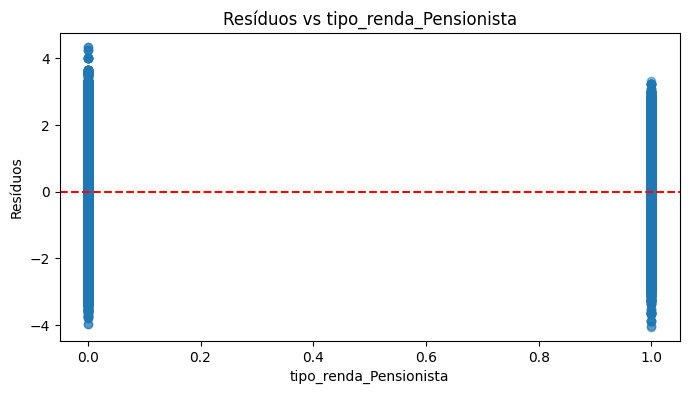

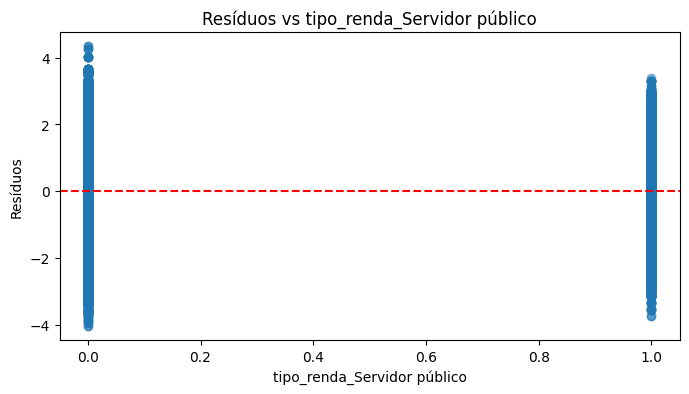

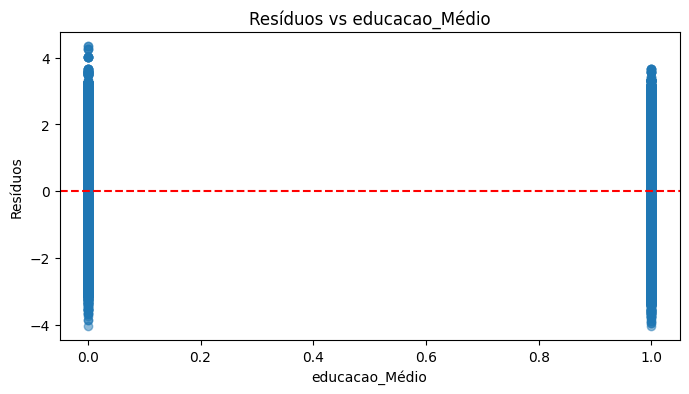

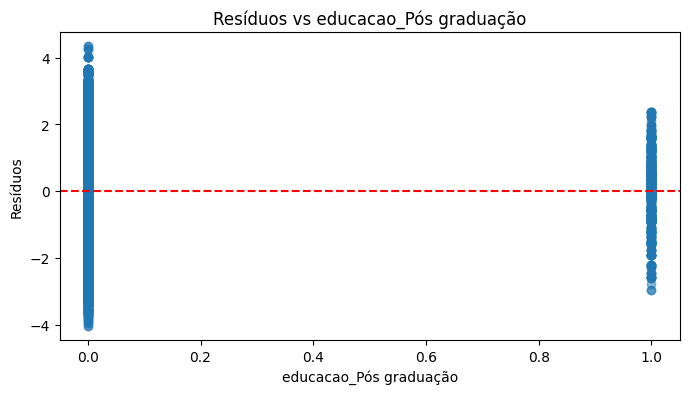

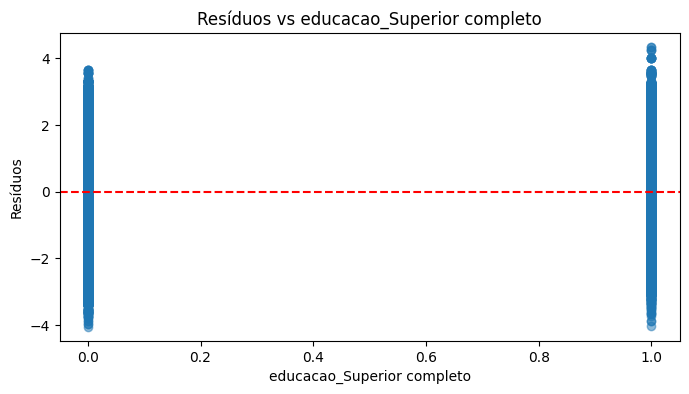

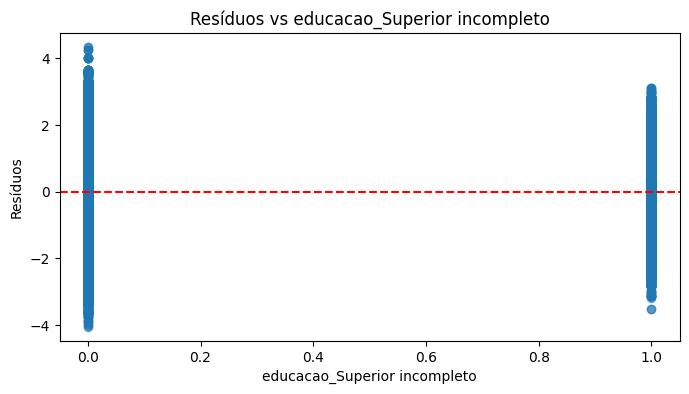

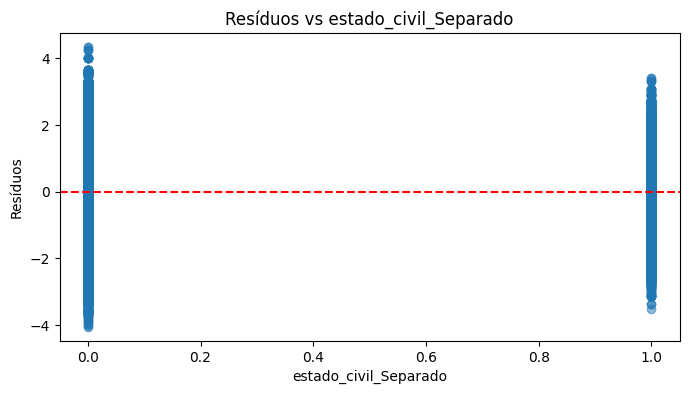

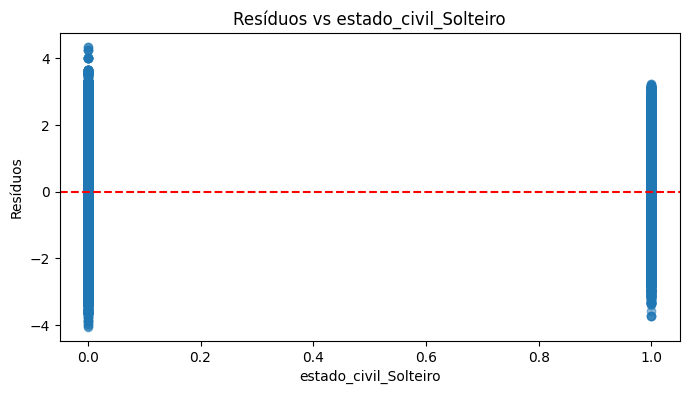

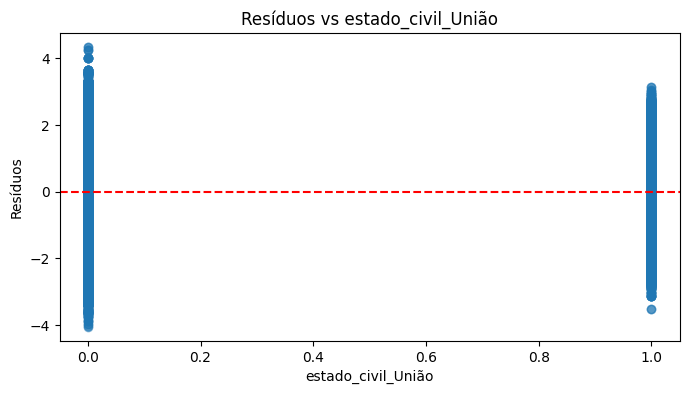

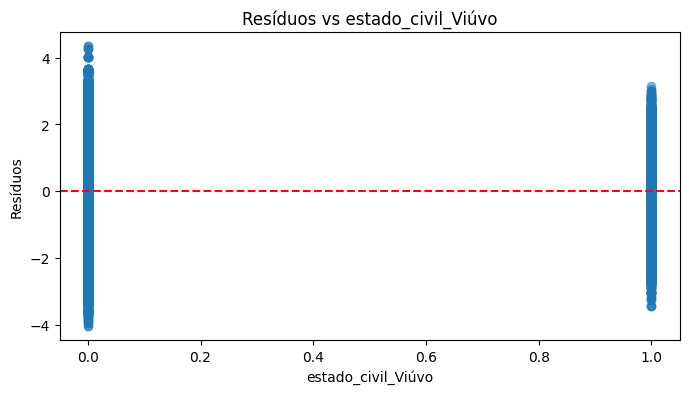

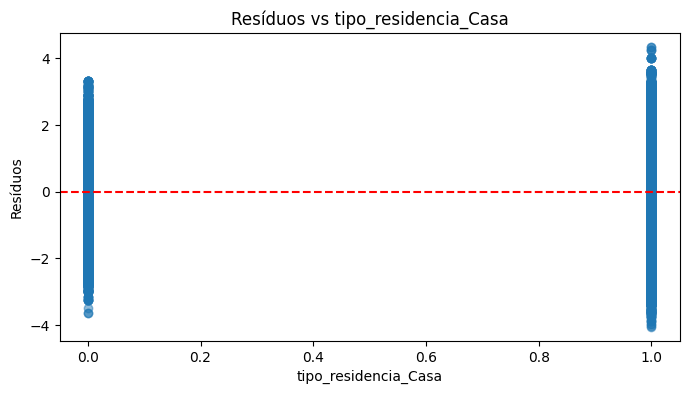

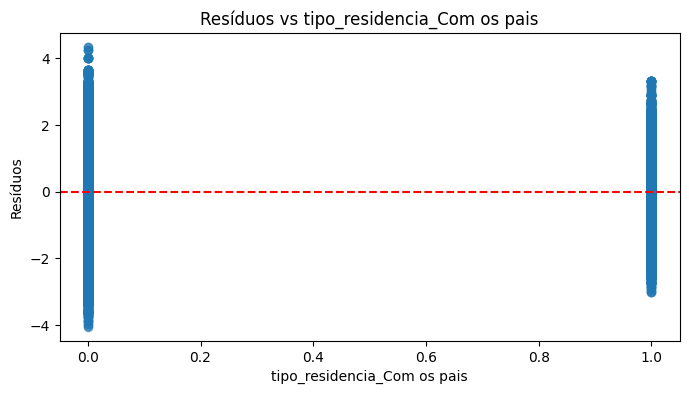

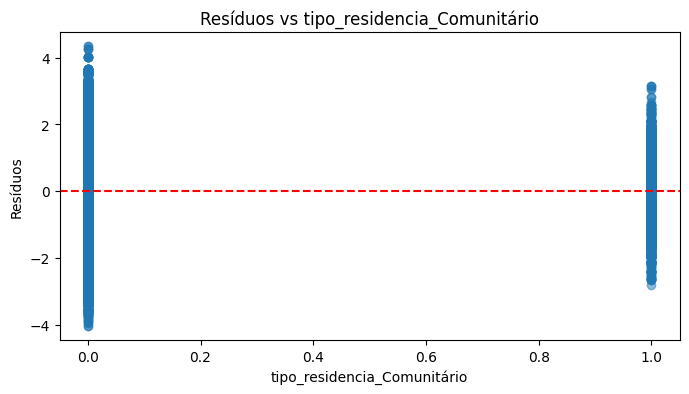

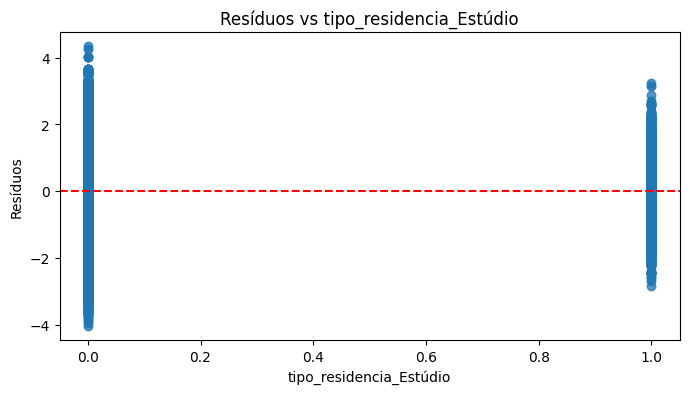

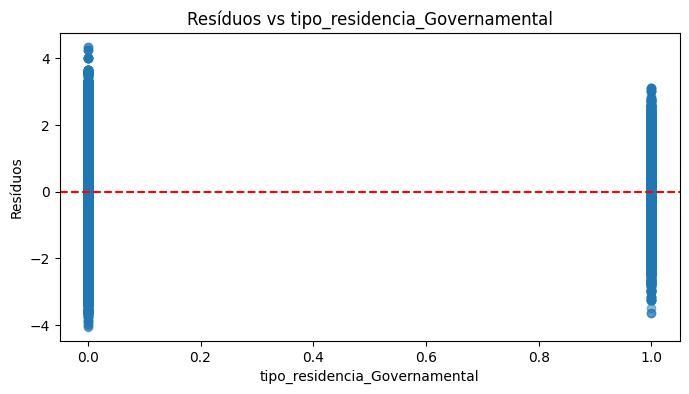

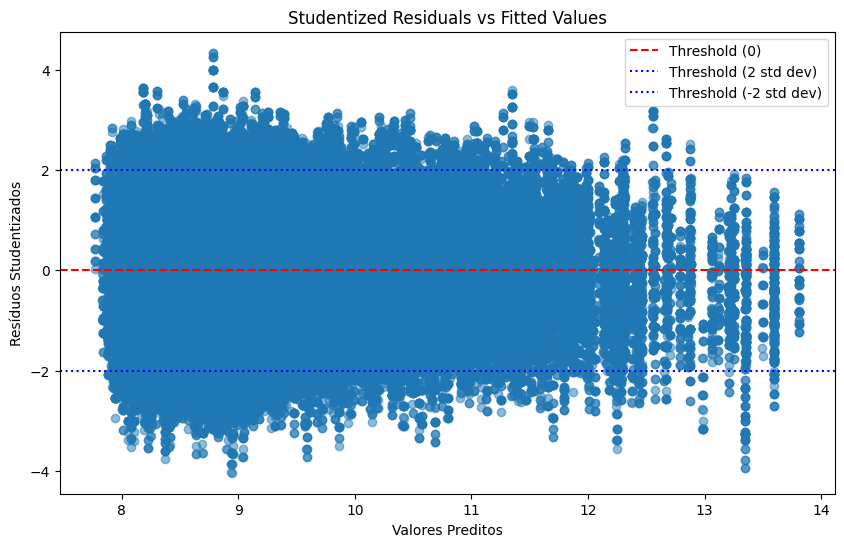

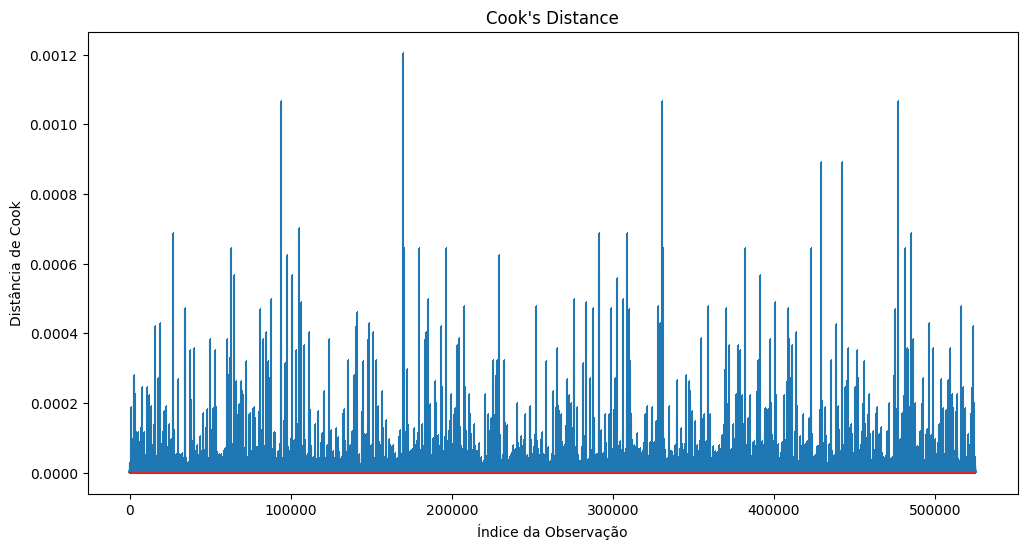

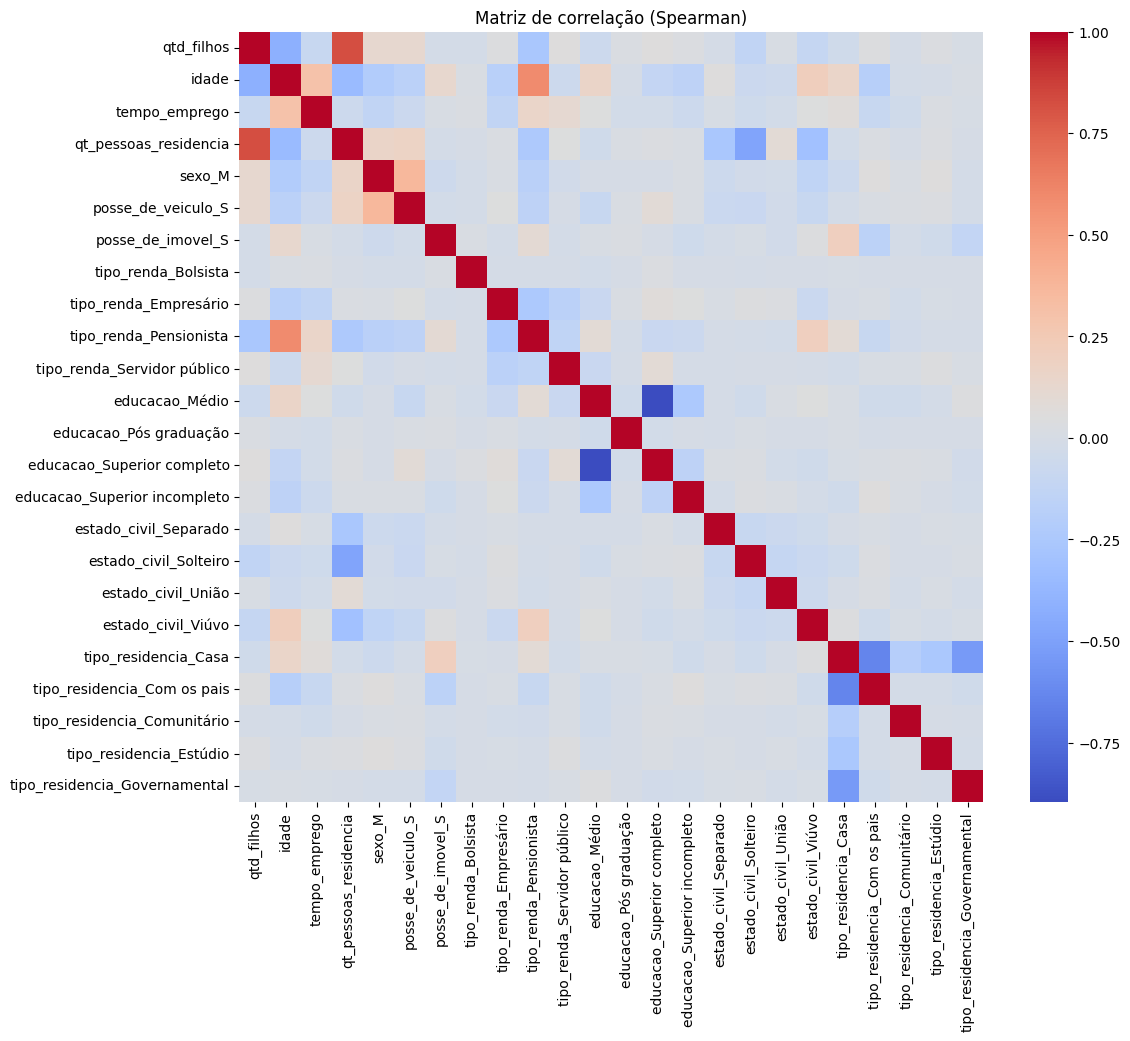

                          feature         VIF
0                           const         inf
4           qt_pessoas_residencia  296.891522
1                      qtd_filhos  199.316887
17          estado_civil_Solteiro   39.622839
12                 educacao_Médio   21.786801
14     educacao_Superior completo   21.002583
16          estado_civil_Separado   20.449308
19             estado_civil_Viúvo   15.738960
20           tipo_residencia_Casa    6.707858
15   educacao_Superior incompleto    4.381979
21    tipo_residencia_Com os pais    4.014981
24  tipo_residencia_Governamental    3.180036
2                           idade    2.163122
10         tipo_renda_Pensionista    1.828371
23        tipo_residencia_Estúdio    1.525732
22    tipo_residencia_Comunitário    1.320944
5                          sexo_M    1.226873
6              posse_de_veiculo_S    1.198264
3                   tempo_emprego    1.156393
9           tipo_renda_Empresário    1.137458
11    tipo_renda_Servidor público 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Carregar base
df = pd.read_csv('/content/previsao_de_renda2.csv')

# 2. Pré-processamento
df = df.drop(columns=["data_ref", "index"], errors="ignore")

# Preencher missings para colunas numéricas antes de qualquer outra transformação
df = df.fillna(df.mean(numeric_only=True))

# Aplicar log na renda
df["renda"] = np.log(df["renda"])  # transformação log

# Separar X e y
X = df.drop(columns=["renda"])
y = df["renda"]

# Gerar variáveis dummy para todas as variáveis categóricas de uma vez no conjunto completo
# Isso garante que X_train_const e X_test_const terão as mesmas colunas
# Use dtype=float para garantir que as novas colunas dummy sejam numéricas (float)
X_dummies = pd.get_dummies(X, drop_first=True, dtype=float)

# Separar treino e teste com as variáveis dummy já criadas
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

# Adicionar a constante ao conjunto de treino e teste
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Garantir que todas as colunas sejam numéricas (float) e que os dataframes estejam alinhados
# Isso resolve o ValueError: Pandas data cast to numpy dtype of object
for col in X_train_const.columns:
    X_train_const[col] = pd.to_numeric(X_train_const[col], errors='coerce')
    # Preencher NaNs que podem surgir se alguma conversão falhar (embora menos provável após get_dummies)
    X_train_const[col] = X_train_const[col].fillna(0) # Substitui NaN por 0, comum para dummies

    # Garantir que X_test_const tenha as mesmas colunas e tipos
    if col not in X_test_const.columns:
        X_test_const[col] = 0 # Adiciona a coluna se ela existe no treino mas não no teste
    else:
        X_test_const[col] = pd.to_numeric(X_test_const[col], errors='coerce')
        X_test_const[col] = X_test_const[col].fillna(0)

# Alinhar as colunas do X_test_const com X_train_const para evitar erros na predição
X_test_const = X_test_const[X_train_const.columns]

# Explicitamente converter todas as colunas para float para garantir compatibilidade com statsmodels
X_train_const = X_train_const.astype(float)
X_test_const = X_test_const.astype(float)

# Ajustar modelo OLS
model = sm.OLS(y_train, X_train_const).fit()

print(model.summary())

# 3. Diagnóstico dos resíduos
residuals = model.resid
fitted = model.fittedvalues

# Normalidade
sns.histplot(residuals, kde=True)
plt.title("Distribuição dos resíduos")
plt.show()
sm.qqplot(residuals, line='s')
plt.title("QQ-Plot dos resíduos")
plt.show()

# Independência (resíduos vs ordem) - Plotar resíduos em relação ao índice
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(residuals)), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos ao longo das observações")
plt.xlabel("Índice da Observação")
plt.ylabel("Resíduos")
plt.show()

# Resíduos vs valores preditos
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Resíduos vs Valores preditos")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.show()

# Resíduos vs variáveis independentes
# Excluir a constante para este loop
for col in X_train.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(X_train[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Resíduos vs {col}")
    plt.xlabel(col)
    plt.ylabel("Resíduos")
    plt.show()

# 4. Outliers e pontos influentes
influence = OLSInfluence(model)
student_resid = influence.resid_studentized_internal

plt.figure(figsize=(10, 6))
plt.scatter(fitted, student_resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Threshold (0)')
plt.axhline(2, color='blue', linestyle=':', label='Threshold (2 std dev)')
plt.axhline(-2, color='blue', linestyle=':', label='Threshold (-2 std dev)')
plt.title("Studentized Residuals vs Fitted Values")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos Studentizados")
plt.legend()
plt.show()

# Pontos influentes (Cook's distance)
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Índice da Observação")
plt.ylabel("Distância de Cook")
plt.show()

# 5. Multicolinearidade
# A matriz de correlação já é baseada em X_dummies, que é numérica
plt.figure(figsize=(12, 10))
corr = X_train.corr(method="spearman")
sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f") # annot=False para melhor visualização com muitas variáveis
plt.title("Matriz de correlação (Spearman)")
plt.show()

# VIF
# Adicionar uma pequena constante para evitar divisão por zero se houver variância zero em alguma dummy
X_vif = sm.add_constant(X_train)

# Assegurar que X_vif é totalmente numérico e sem NaNs antes de calcular VIF
for col in X_vif.columns:
    X_vif[col] = pd.to_numeric(X_vif[col], errors='coerce')
    X_vif[col] = X_vif[col].fillna(0) # Preenche NaNs com 0

# Explicitamente converter todas as colunas de X_vif para float
X_vif = X_vif.astype(float)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
# Tratar casos onde o VIF pode ser infinito (colunas linearmente dependentes)
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) if np.std(X_vif.values[:,i]) > 0 else np.inf for i in range(X_vif.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

# 6. Avaliar desempenho
y_pred_train = model.predict(X_train_const)
y_pred_test = model.predict(X_test_const)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\nRMSE Treino:", rmse_train)
print("RMSE Teste:", rmse_test)
